#Import necessary library

In [2]:
!pip install transformers
!pip install Sastrawi

import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import f1_score
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Sastrawi-1.0.1-py2.py3-none-any.whl (209 kB)


#Load & Preprocess the data

In [3]:
df = pd.read_csv("clean_tweets.csv")
df = df.dropna()

# Remove stop words using Sastrawi library
factory = StopWordRemoverFactory()
stop_words = factory.create_stop_word_remover()
df['Tweet'] = df['Tweet'].apply(lambda x: stop_words.remove(x))

# Map labels to integers
label_map = {"positive": 1, "negative": 0}
df['label'] = df['label'].map(label_map)

# Split data into train and test sets
train_text, test_text, train_labels, test_labels = train_test_split(df['Tweet'].values, df['label'].values, test_size=0.2, random_state=42)


#Tokenize data using BERT tokenizer

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)

# Encode train and test data using BERT tokenizer
train_encodings = tokenizer(train_text.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_text.tolist(), truncation=True, padding=True)

# Convert encoded inputs to PyTorch tensors
train_inputs = torch.tensor(train_encodings['input_ids'])
train_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(train_labels)
test_inputs = torch.tensor(test_encodings['input_ids'])
test_masks = torch.tensor(test_encodings['attention_mask'])
test_labels = torch.tensor(test_labels)

# Create data loaders for efficient batching
batch_size = 16
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


#Train the model

In [5]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2, output_attentions=False, output_hidden_states=False)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer and scheduler
epochs = 5
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

from tqdm import tqdm

# Train the model
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}', leave=False)
    for step, batch in enumerate(progress_bar):
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)
        batch_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        avg_train_loss = total_loss / (step+1)
        progress_bar.set_postfix({'training_loss': avg_train_loss})
    print(f'Epoch: {epoch + 1}, Training Loss: {avg_train_loss}')




Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

Epoch: 1, Training Loss: 0.4913615642404053


Epoch: 2, Training Loss: 0.30799799082984386


Epoch: 3, Training Loss: 0.2239837759567923


Epoch: 4, Training Loss: 0.1635113817196943


Epoch: 5, Training Loss: 0.1255729002938737


#Save the trained model

In [21]:
model_path = 'bert_sa_sentiment_model.pt'
torch.save(model.state_dict(), model_path)

#Evaluate the model

In [23]:
# Load the saved model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2, output_attentions=False, output_hidden_states=False)
model.load_state_dict(torch.load(model_path))
model.to(device)

# Evaluate the model on test data
model.eval()
total_preds = []
total_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        batch_inputs = batch[0].to(device)
        batch_masks = batch[1].to(device)
        batch_labels = batch[2].to('cpu')
        outputs = model(batch_inputs, attention_mask=batch_masks)
        logits = outputs[0]
        preds = torch.argmax(logits, axis=1)
        total_preds.extend(preds)
        total_labels.extend(batch_labels)

total_labels = torch.tensor(total_labels)
total_preds = torch.tensor(total_preds)

# Calculate F1 score
f1 = f1_score(total_labels.detach().cpu().numpy(), total_preds.detach().cpu().numpy(), average='weighted')
print(f'Weighted F1 score: {f1:.4f}')


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

Weighted F1 score: 0.8522


#Use the trained model for inference

In [24]:
def predict_sentiment(text):
    # Remove stop words from input text

    text = stop_words.remove(text)
    # Tokenize input text using BERT tokenizer
    encoding = tokenizer.encode_plus(text, max_length=64, truncation=True, padding='max_length', add_special_tokens=True, return_attention_mask=True, return_tensors='pt')
    inputs = encoding['input_ids'].to(device)
    masks = encoding['attention_mask'].to(device)
    # Pass input through the trained model and return predicted sentiment
    with torch.no_grad():
        outputs = model(inputs, attention_mask=masks)
        logits = outputs[0]
        probs = torch.softmax(logits, dim=1)
        _, pred_label = torch.max(probs, dim=1)
    return 'positive' if pred_label == 1 else 'negative'


#Result

In [25]:
text = "Bodoh kamu"
sentiment = predict_sentiment(text)
print(sentiment)


negative


In [26]:
text = "Ditengah masyarakat yg gak begitu suka baca dan lebih tertarik dengan hal2 visual, Ganjar dan Prabowo lebih ahlinya, sedikit membicarakan data, jaranga mengkritiki, tapi lebih sering tampil di media, mau beritanya buruk atau baik, atau biasa2 aja, jumlah mereka muncul di media nasional lebih banyak dari Anies."
sentiment = predict_sentiment(text)
print(sentiment)

positive


In [27]:
text = "Insya Allah Pak Anies Presiden  2024 ini akun bayaran dan survei bayaran"
sentiment = predict_sentiment(text)
print(sentiment)

positive


In [28]:
text = "Sampai skrg saya bingung apa ide dan gagasan perubahan dari Anies? Sampai skrg ini, Anies masih berkutat menyinggung program program Jokowi belum ada suatu hal yang besar ide perubahan yang selalu diusung oleh Anies."
sentiment = predict_sentiment(text)
print(sentiment)

negative


In [29]:
predict = pd.read_csv('proces.csv')
predict.head()

,Unnamed: 0,Caption,tokenized,freqdist,tokens_WSW,normalized,tokens_stemmed,merged
0,5,hehwowkwowk waktu pilgub jakarta juga peringka...,"['hehwowkwowk', 'waktu', 'pilgub', 'jakarta', ...",<FreqDist with 9 samples and 10 outcomes>,"['hehwowkwowk', 'pilgub', 'jakarta', 'peringka...","['hehwowkwowk', 'pilgub', 'jakarta', 'peringka...","['hehwowkwowk', 'pilgub', 'jakarta', 'peringka...",hehwowkwowk pilgub jakarta peringkat mulu
1,6,menang survei kok bangga liat aja dilapangan m...,"['menang', 'survei', 'kok', 'bangga', 'liat', ...",<FreqDist with 11 samples and 11 outcomes>,"['menang', 'survei', 'bangga', 'liat', 'dilapa...","['menang', 'survei', 'bangga', 'lihat', 'dilap...","['menang', 'survei', 'bangga', 'lihat', 'lapan...",menang survei bangga lihat lapang masyarakat c...
2,7,pernyataan seperti ini jadi keinget sama perny...,"['pernyataan', 'seperti', 'ini', 'jadi', 'kein...",<FreqDist with 49 samples and 54 outcomes>,"['pernyataan', 'keinget', 'pernyataan', 'pakar...","['pernyataan', 'keinget', 'pernyataan', 'pakar...","['nyata', 'keinget', 'nyata', 'pakar', 'media'...",nyata keinget nyata pakar media pesimis formul...
3,8,tiga aja di jegal di takuti bagaimana kalau no...,"['tiga', 'aja', 'di', 'jegal', 'di', 'takuti',...",<FreqDist with 16 samples and 17 outcomes>,"['jegal', 'takuti', 'no', 'kejang', 'insya', '...","['jegal', 'takuti', 'no', 'kejang', 'insya', '...","['jegal', 'takut', 'no', 'kejang', 'insya', 'a...",jegal takut no kejang insya allah anies presiden
4,9,lah emang konsep perubahan yang di tawarkan ol...,"['lah', 'emang', 'konsep', 'perubahan', 'yang'...",<FreqDist with 13 samples and 13 outcomes>,"['emang', 'konsep', 'perubahan', 'tawarkan', '...","['emang', 'konsep', 'perubahan', 'tawarkan', '...","['emang', 'konsep', 'ubah', 'tawar', 'ganjar',...",emang konsep ubah tawar ganjar prabowo


In [30]:
predict.drop(['Unnamed: 0', 'tokenized', 'freqdist', 'tokens_WSW', 'tokens_stemmed', 'normalized'], inplace=True, axis=1)

In [31]:
predict = predict.dropna()

In [32]:
predict.head(10)

,Caption,merged
0,hehwowkwowk waktu pilgub jakarta juga peringka...,hehwowkwowk pilgub jakarta peringkat mulu
1,menang survei kok bangga liat aja dilapangan m...,menang survei bangga lihat lapang masyarakat c...
2,pernyataan seperti ini jadi keinget sama perny...,nyata keinget nyata pakar media pesimis formul...
3,tiga aja di jegal di takuti bagaimana kalau no...,jegal takut no kejang insya allah anies presiden
4,lah emang konsep perubahan yang di tawarkan ol...,emang konsep ubah tawar ganjar prabowo
5,sampai skrg saya bingung apa ide dan gagasan p...,sekarang bingung ide gagas ubah anies sekarang...
6,waktu mendekati pilkada dki juga posisi elekta...,dekat pilkada dki posisi elektabilitas anies u...
7,karna pak anis kaga punya duit buat nyewa lemb...,karna anies tidak duit nyewa lembaga survey mi...
8,yang dukung anies punya kepentingan memang ga ...,dukung anies penting didik kena tipu
9,kalo emang survei elektabilitas ini bisa jadi ...,emang survei elektabilitas acu hasil ahok udah...


In [33]:
# Assuming you have already imported the necessary libraries and have the DataFrame `data` with the desired column

# Create an empty list to store the predicted sentiments
predicted_sentiments = []

# Iterate through the column values using a loop
for text in predict['merged']:
    # Check if the value is a string
    if isinstance(text, str):
        # Apply the predict_sentiment() function to each text value
        sentiment = predict_sentiment(text)
    else:
        # Handle non-string values (e.g., NaN or float)
        sentiment = 'Unknown'
    # Append the predicted sentiment to the list
    predicted_sentiments.append(sentiment)

# Print or manipulate the list of predicted sentiments
for sentiment in predicted_sentiments:
    print(sentiment)

positive
positive
negative
negative
positive
negative
positive
negative
negative
positive
positive
positive
positive
positive
positive
positive
positive
negative
positive
positive
positive
positive
positive
positive
positive
negative
positive
negative
positive
positive
positive
positive
positive
positive
positive
positive
positive
positive
positive
negative
positive
negative
positive
positive
positive
negative
positive
positive
positive
positive
positive
negative
negative
positive
positive
positive
negative
positive
negative
positive
positive
negative
positive
positive
negative
positive
positive
positive
positive
positive
positive
positive
positive
positive
negative
positive
negative
positive
positive
positive
positive
positive
positive
positive
positive
positive
positive
positive
positive
negative
negative
positive
positive
negative
positive
positive
negative
negative
positive
positive
positive
positive
positive
negative
positive
positive
positive
positive
positive
positive
positive
n

In [34]:
# Add the predicted_sentiments list as a new column to the DataFrame
predict['predicted_sentiments'] = predicted_sentiments

# Write the updated DataFrame to the CSV file
predict.to_csv('predict2.csv', index=False)

In [35]:

label_counts = predict['predicted_sentiments'].value_counts()


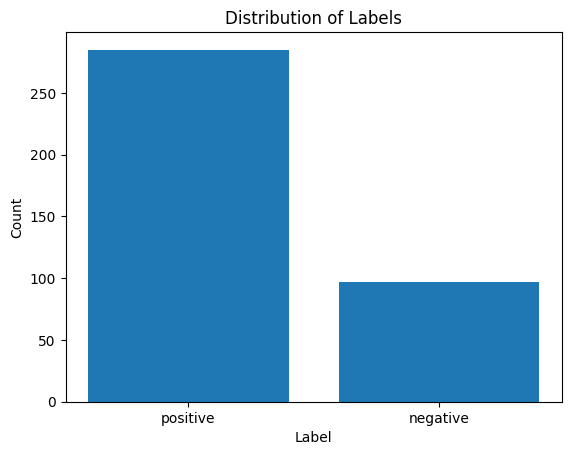

In [36]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.bar(label_counts.index, label_counts.values)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Show the plot
plt.show()
